198
(784,)
(23,)


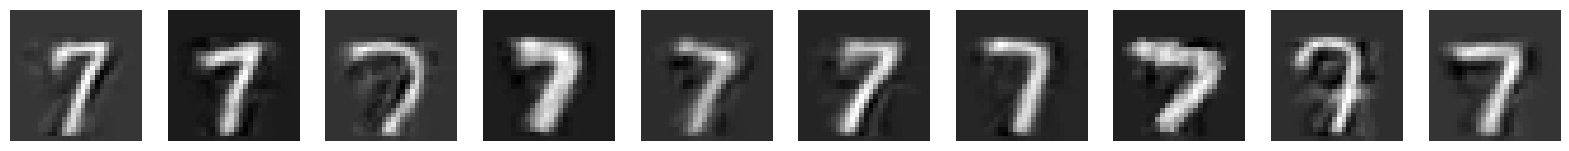

In [75]:
import numpy as np
import torch
from torchvision import datasets, transforms
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MNIST data loading
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambda x: torch.flatten(x))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)

# Load a batch of images and their corresponding labels
images_labels = next(iter(train_loader))
# 筛选出label为1的
images = images_labels[0][images_labels[1] == 7]
# images = images_labels[0][:]
print(len(images))

images = images.numpy()


# Dimensionality reduction with PCA
pca = PCA(n_components=0.8, whiten=True)
images_pca = pca.fit_transform(images)
print(images[0].shape)
print(images_pca[0].shape)

# Train GMM
gmm = GaussianMixture(n_components=100, covariance_type='full', random_state=0)
gmm.fit(images_pca)

# Sample new data and transform it back to original space
new_samples, _ = gmm.sample(10)
new_images = pca.inverse_transform(new_samples)
new_images = new_images.reshape((10, 28, 28))  # Reshape to original image dimensions

# Visualize the new images
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 4))
for ax, image in zip(axes, new_images):
    ax.imshow(image, cmap='gray')
    ax.axis('off')
plt.show()


tensor([0])
12460


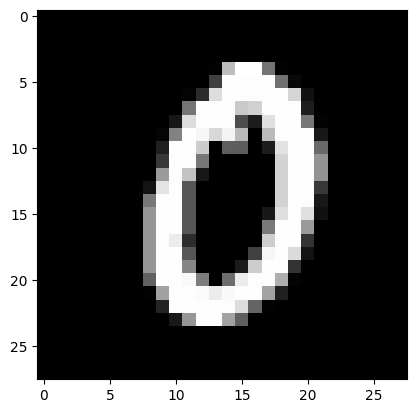

In [1]:
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import torch

# 加载MNIST数据集
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(root='./dataset/GMM', train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1, shuffle=True)

a=next(iter(loader))
print(a[1])
image=a[0].squeeze()
import random
# 提取灰度值较高的像素坐标
# for i in range(len(image[0])):
#     for j in range(len(image[1])):
#         if 5<=i<=20 and 19<=j<=20 or 5<=i<=20 and 5<=j<=6 or 5<=i<=6 and 5<=j<=20 or 19<=i<=20 and 5<=j<=20:
#         # if i-j<=5 and i-j>=-5:
#         #   image[i][j]=random.randint(128,255)
#             image[i][j]=255
plt.imshow(image, cmap='gray')  

coords = []
image = image.numpy()

# 标准化灰度值到[0, 1]
image = image / image.max()
# 计算每个像素的出现次数
counts = (image * 100).astype(int)
y, x = np.where(image >= 0)
for i, j in zip(y, x):
    # 根据灰度值重复坐标
    coords.extend([(j, i)] * counts[i, j])

print(len(coords))
# 限制坐标数量，以便于处理
coords = np.array(coords)
plt.imshow(image, cmap='gray')  



# 生成新的样本点
# samples, _ = gmm.sample(1000)

# # 可视化
# plt.scatter(samples[:, 0], samples[:, 1], alpha=0.6)
# plt.gca().invert_yaxis()
# plt.show()


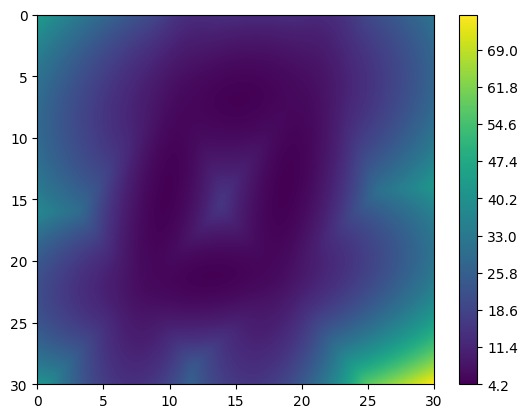

In [8]:
# 使用GMM拟合坐标
gmm = GaussianMixture(n_components=4, random_state=0)
gmm.fit(coords)
# 创建一个网格区域来计算GMM的概率密度
x = np.linspace(0, 30, 500)
y = np.linspace(0, 30, 500)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm.score_samples(XX)  # 计算每个点的负对数似然值
Z = Z.reshape(X.shape)
# 使用contourf画出概率密度，概率密度越高的地方越暗
plt.contourf(X, Y, Z, levels=500, cmap='viridis')
plt.gca().invert_yaxis()
plt.colorbar() 
plt.show()

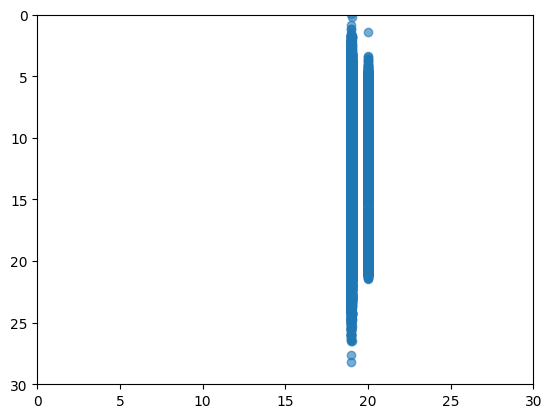

In [81]:
samples, _ = gmm.sample(100000)

# 可视化
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.6)
plt.xlim(0,30)
plt.ylim(0,30)
plt.gca().invert_yaxis()

plt.show()

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# 定义一个函数来生成长方形内的点
def generate_rectangle_points(length, width, n_points=1000):
    """
    生成一个长方形区域内的随机点。
    
    参数:
    - length: 长方形的长度
    - width: 长方形的宽度
    - n_points: 生成的点的数量
    
    返回:
    - points: 长方形内的点的坐标数组
    """
    points = np.random.rand(n_points, 2)
    points[:, 0] *= length
    points[:, 1] *= width
    return points

# 定义一个函数来评估使用不同数量的GMM组分来拟合数据的效果
def estimate_gmm_components_for_rectangle(length, width, max_components=10, n_points=1000):
    """
    评估拟合长方形所需的最少GMM组分数。
    
    参数:
    - length: 长方形的长度
    - width: 长方形的宽度
    - max_components: 尝试的最大GMM组分数
    - n_points: 生成的点的数量
    
    返回:
    - best_n_components: 最佳组分数
    - best_score: 对应的轮廓系数
    """
    points = generate_rectangle_points(length, width, n_points)
    best_score = -1
    best_n_components = 1
    
    for n_components in range(2, max_components + 1):
        gmm = GaussianMixture(n_components=n_components, random_state=0).fit(points)
        labels = gmm.predict(points)
        score = silhouette_score(points, labels)
        print(labels,score,n_components)
        if score > best_score:
            best_score = score
            best_n_components = n_components
    
    return best_n_components, best_score

# 以一个具体的长方形为例（例如长度10，宽度2），评估所需的GMM组分数
estimate_gmm_components_for_rectangle(10, 2)


[1 1 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0
 1 0 0 1 0 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1
 1 1 0 0 0 1 0 0 0 0 1 1 0 1 1 1 1 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 0 1 0 1 1
 0 1 1 0 0 1 1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0
 0 0 1 1 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 1 0 0 1
 1 1 1 0 0 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 0
 0 0 1 0 0 0 1 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0 0 0 0 0 0 1 1
 0 0 1 1 1 1 0 0 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 0 0 0 1 1 1 0 0 1
 1 1 0 0 0 1 1 1 0 0 0 1 1 0 1 1 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 1 0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 1 0 1 0 1 1 0 1 1
 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0
 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 1 0 0 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1
 0 1 0 0 0 0 1 1 0 1 1 1 

(2, 0.5686820628820939)

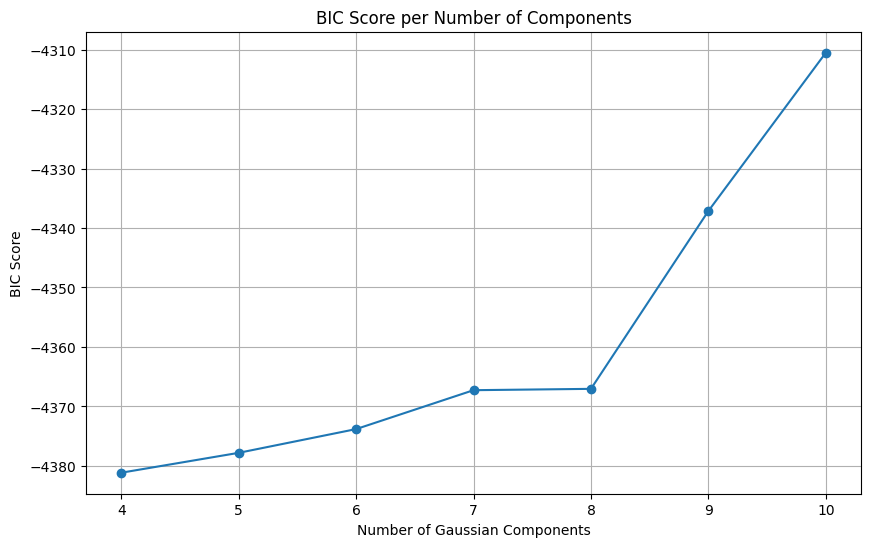

In [100]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt

# 定义长方形的尺寸
length = 15
width = 5

# 生成长方形边界上的点
def generate_rectangle_points(length, width, num_points=1000):
    # 每边分配点的数量
    points_per_side = num_points // 4
    
    # 长边
    x_long = np.linspace(0, length, points_per_side)
    y_long = np.zeros(points_per_side)
    
    # 宽边
    x_short = np.zeros(points_per_side)
    y_short = np.linspace(0, width, points_per_side)
    
    # 生成四边的点
    top = np.vstack((x_long, y_long + width))
    bottom = np.vstack((x_long, y_long))
    left = np.vstack((x_short, y_short))
    right = np.vstack((x_short + length, y_short))
    
    # 合并并转置以获得正确的形状
    points = np.hstack((top, bottom, left, right)).T
    
    return points

# 生成长方形点集
points = generate_rectangle_points(length, width)

# 尝试使用4到10个高斯组件的GMM拟合点集，并计算BIC值
bic_values = []
n_components_range = range(4, 11)
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full')
    gmm.fit(points)
    bic_values.append(gmm.bic(points))

# 绘制BIC值以查找最优的高斯组件数量
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic_values, marker='o')
plt.title('BIC Score per Number of Components')
plt.xlabel('Number of Gaussian Components')
plt.ylabel('BIC Score')
plt.xticks(n_components_range)
plt.grid(True)
plt.show()


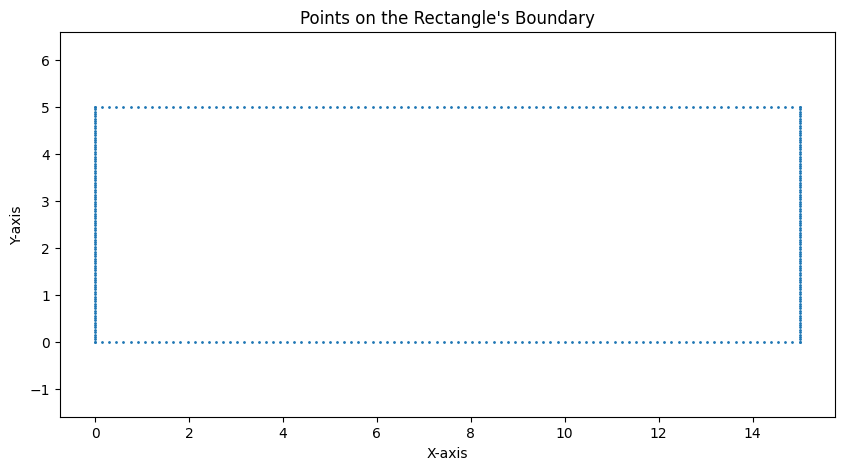

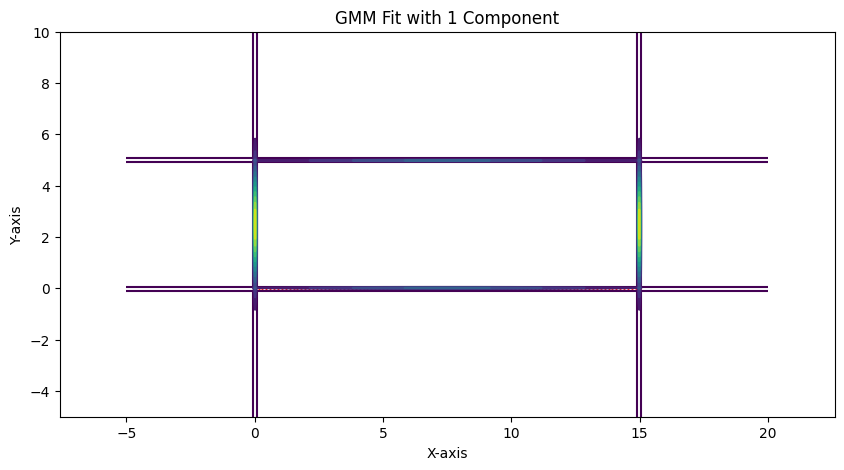

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# 长方形的尺寸
width = 15
height = 5

# 在长方形边界上生成点集
# 分配点的数量到每条边上，考虑到长宽比和点的分布
num_points_per_side = 100
x_left = np.linspace(0, 0, num_points_per_side)
y_left = np.linspace(0, height, num_points_per_side)

x_right = np.linspace(width, width, num_points_per_side)
y_right = np.linspace(0, height, num_points_per_side)

x_bottom = np.linspace(0, width, num_points_per_side)
y_bottom = np.linspace(0, 0, num_points_per_side)

x_top = np.linspace(0, width, num_points_per_side)
y_top = np.linspace(height, height, num_points_per_side)

# 合并这些点以形成完整的轮廓
x = np.concatenate([x_left, x_right, x_bottom, x_top])
y = np.concatenate([y_left, y_right, y_bottom, y_top])
points = np.vstack((x, y)).T

# 绘制这些点以可视化长方形轮廓
plt.figure(figsize=(10, 5))
plt.scatter(points[:, 0], points[:, 1], s=1)
plt.title("Points on the Rectangle's Boundary")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.axis('equal')
plt.show()

# 返回点集以供后续步骤使用
points

# 使用1个GMM组件拟合长方形轮廓点
gmm = GaussianMixture(n_components=4, random_state=0).fit(points)

# 生成一些数据点来可视化GMM拟合的结果
x_values = np.linspace(-5, 20, 300)
y_values = np.linspace(-5, 10, 300)
x_grid, y_grid = np.meshgrid(x_values, y_values)
xy_grid = np.array([x_grid.ravel(), y_grid.ravel()]).T

# 计算网格上每点的GMM分数
gmm_scores = gmm.score_samples(xy_grid)
gmm_scores = gmm_scores.reshape(x_grid.shape)

# 绘制GMM拟合结果
plt.figure(figsize=(10, 5))
plt.contour(x_grid, y_grid, np.exp(gmm_scores), levels=15)
plt.scatter(points[:, 0], points[:, 1], s=1, color='red')
plt.title("GMM Fit with 1 Component")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.axis('equal')
plt.show()



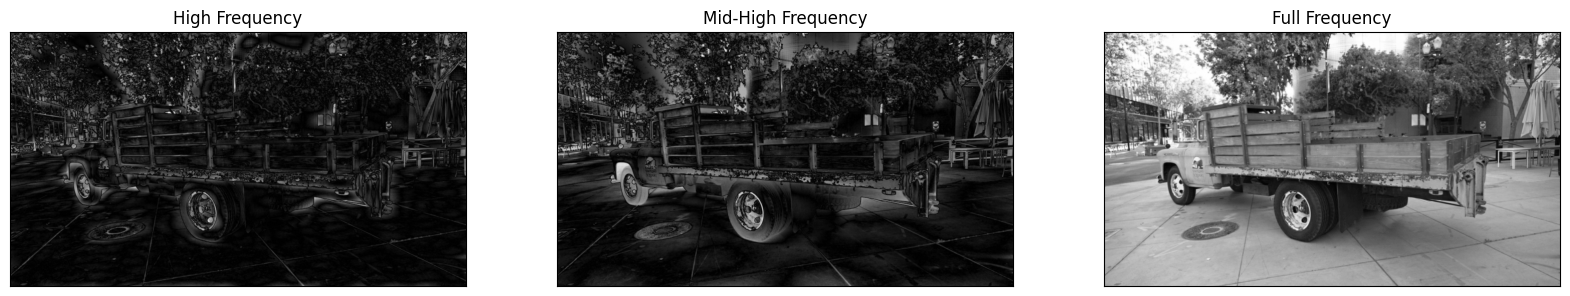

In [24]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Load the image
image = cv2.imread('output/dense_truck_voxeldown/test/ours_30000/gt/00000.png', cv2.IMREAD_GRAYSCALE)

# Compute the 2D Fourier transform of the image
f = np.fft.fft2(image)
fshift = np.fft.fftshift(f)

# Compute the magnitude spectrum
magnitude_spectrum = 20*np.log(np.abs(fshift))

# Create masks for high frequency, mid-high frequency, and full frequency components
rows, cols = image.shape
crow, ccol = rows//2 , cols//2

# High frequency mask
mask_high = np.zeros((rows, cols), np.uint8)
r_mid = 15 # less radius means more high frequency
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area_high = (x - center[0]) ** 2 + (y - center[1]) ** 2 >= r_mid*r_mid
mask_high[mask_area_high] = 1

# Mid-high frequency mask (larger radius includes more frequencies)
mask_mid_high = np.zeros((rows, cols), np.uint8)
r = 5 # greater radius includes mid-high frequencies
mask_area_mid_high = (x - center[0]) ** 2 + (y - center[1]) ** 2 >= r*r
mask_mid_high[mask_area_mid_high] = 1

# Apply masks to Fourier transformed image
fshift_high = fshift * mask_high
fshift_mid_high = fshift * mask_mid_high
fshift_full = fshift

# Inverse Fourier transform to get the image back
img_back_high = np.fft.ifft2(np.fft.ifftshift(fshift_high))
img_back_mid_high = np.fft.ifft2(np.fft.ifftshift(fshift_mid_high))
img_back_full = np.fft.ifft2(np.fft.ifftshift(fshift_full))

# Show images
plt.figure(figsize=(20, 80))

plt.subplot(131),plt.imshow(np.abs(img_back_high), cmap = 'gray')
plt.title('High Frequency'), plt.xticks([]), plt.yticks([])

plt.subplot(132),plt.imshow(np.abs(img_back_mid_high), cmap = 'gray')
plt.title('Mid-High Frequency'), plt.xticks([]), plt.yticks([])

plt.subplot(133),plt.imshow(np.abs(img_back_full), cmap = 'gray')
plt.title('Full Frequency'), plt.xticks([]), plt.yticks([])

plt.show()


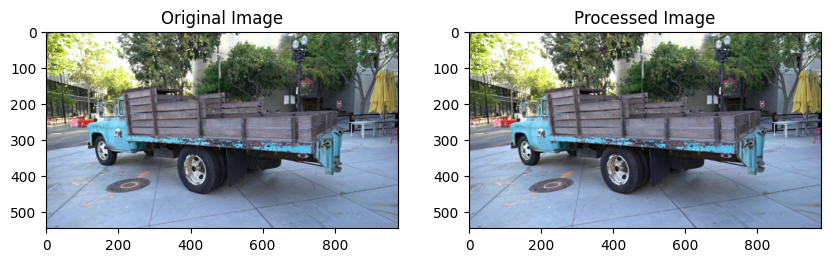

In [25]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# 加载图像
image_path = 'output/dense_truck_voxeldown/test/ours_30000/gt/00000.png' # 确保这里是你图像的正确路径
image = cv2.imread(image_path) # 以彩色模式加载

# 将BGR图像转换为RGB图像，因为Matplotlib默认使用RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 分别处理每个颜色通道
channels = cv2.split(image_rgb)
channels_fft = []
for channel in channels:
    # 对每个通道进行傅里叶变换并中心化
    f = np.fft.fft2(channel)
    fshift = np.fft.fftshift(f)
    # 对频率域图像进行逆变换以可视化
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    channels_fft.append(img_back)

# 合并处理后的通道
image_processed = cv2.merge(channels_fft)

# 展示原始图像和处理后的图像
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(image_rgb), plt.title('Original Image')
plt.subplot(122), plt.imshow(image_processed.astype(np.uint8)), plt.title('Processed Image')
plt.show()


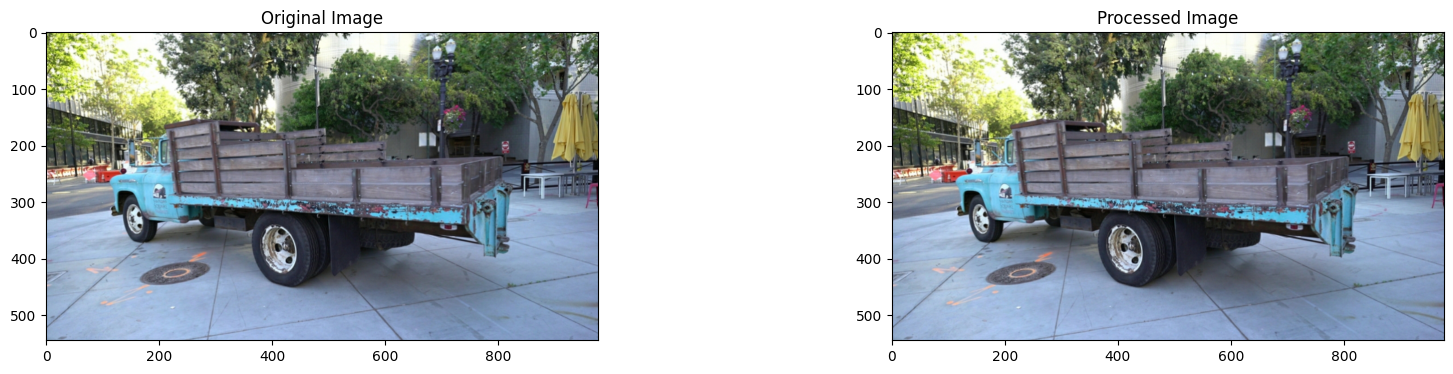

In [32]:
import numpy as np
from scipy.fft import dct, idct
import matplotlib.pyplot as plt
from PIL import Image
 
# 读取RGB图像
image_path = 'output/dense_truck_voxeldown/test/ours_30000/gt/00000.png'  # 请将路径替换为你自己图像的路径
image = Image.open(image_path)
image_array = np.array(image)
 
# 将图像转换为浮点数，并分解为RGB三个通道
image_float = image_array.astype(float)
red_channel = image_float[:, :, 0]
green_channel = image_float[:, :, 1]
blue_channel = image_float[:, :, 2]
 
# 对每个通道进行DCT变换
dct_red = dct(dct(red_channel, axis=0, norm='ortho'), axis=1, norm='ortho')
dct_green = dct(dct(green_channel, axis=0, norm='ortho'), axis=1, norm='ortho')
dct_blue = dct(dct(blue_channel, axis=0, norm='ortho'), axis=1, norm='ortho')
 
# 设定一个阈值，过滤掉低频信息（这里示例阈值为0.1）
threshold = 0.5
dct_red_filtered = dct_red * (np.abs(dct_red) > threshold)
dct_green_filtered = dct_green * (np.abs(dct_green) > threshold)
dct_blue_filtered = dct_blue * (np.abs(dct_blue) > threshold)
 
# 对过滤后的DCT系数进行逆DCT变换
idct_red = idct(idct(dct_red_filtered, axis=0, norm='ortho'), axis=1, norm='ortho')
idct_green = idct(idct(dct_green_filtered, axis=0, norm='ortho'), axis=1, norm='ortho')
idct_blue = idct(idct(dct_blue_filtered, axis=0, norm='ortho'), axis=1, norm='ortho')
 
# 合并三个通道并将浮点数组转换回整数形式
image_result = np.stack((idct_red, idct_green, idct_blue), axis=2).astype(np.uint8)
 
# 显示原始图像和处理后的图像
plt.figure(figsize=(20, 4))
 
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image)
 
plt.subplot(1, 2, 2)
plt.title('Processed Image')
plt.imshow(image_result)
plt.show()

/tmp/ipykernel_1747243/2173468350.py:37: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(img_src_R)), cmap='gray')
/tmp/ipykernel_1747243/2173468350.py:42: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(img_src_G)), cmap='gray')


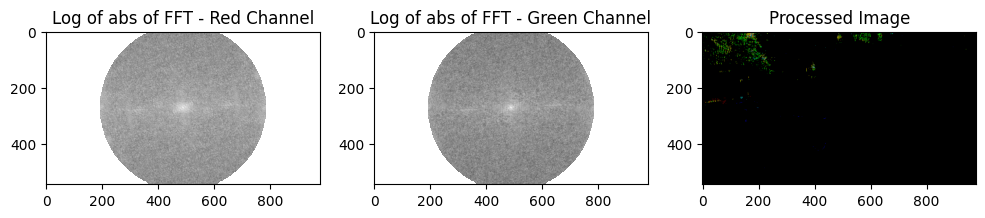

s_max: 74256.25


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift

def low_filter(fshifted, radius):
    """
    简化的低通滤波器，根据给定半径过滤FFT变换后的图像。
    """
    M, N = fshifted.shape
    Y, X = np.ogrid[:M, :N]
    center = (M // 2, N // 2)
    distance = (X - center[1])**2 + (Y - center[0])**2
    mask = distance <= radius**2
    return fshifted * mask

def process_image(img_src, fre):
    """
    应用低通滤波器处理图像。
    """
    # 计算s_max
    a, b, _ = img_src.shape
    s_max = min(a/2, b/2)**2
    
    # 处理每个颜色通道
    for i in range(3):
        A = img_src[:, :, i]
        B = A.astype(float)
        C = low_filter(fftshift(fft2(B)), fre)
        D = np.uint8(np.real(ifft2(ifftshift(C))))
        img_src[:, :, i] = D
    
    # 显示处理结果
    plt.figure(figsize=(12, 6))
    
    plt.subplot(131)
    img_src_R = low_filter(fftshift(fft2(img_src[:, :, 0].astype(float))), fre)
    plt.imshow(np.log(np.abs(img_src_R)), cmap='gray')
    plt.title('Log of abs of FFT - Red Channel')
    
    plt.subplot(132)
    img_src_G = low_filter(fftshift(fft2(img_src[:, :, 1].astype(float))), fre)
    plt.imshow(np.log(np.abs(img_src_G)), cmap='gray')
    plt.title('Log of abs of FFT - Green Channel')
    
    plt.subplot(133)
    plt.imshow(img_src)
    plt.title('Processed Image')
    
    plt.show()
    
    return s_max

# 示例使用
img_src = plt.imread('output/dense_truck_voxeldown/test/ours_30000/gt/00000.png')  # 请替换为你的图像路径
fre = 300  # 示例频率值
s_max = process_image(img_src, fre)
print("s_max:", s_max)


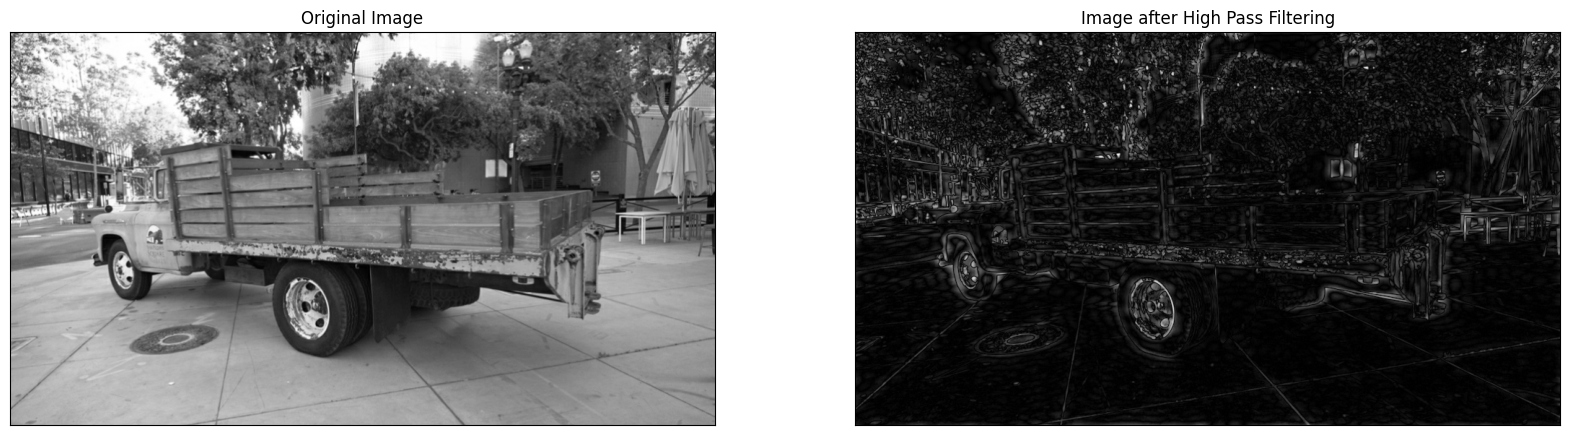

In [40]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Load an image
image_path = 'output/dense_truck_voxeldown/test/ours_30000/gt/00000.png'  # Make sure to use the correct path to your image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load the image in grayscale

# Perform FFT to get the frequency domain representation
f = np.fft.fft2(image)
fshift = np.fft.fftshift(f)

# Get the dimensions of the image
rows, cols = image.shape
crow, ccol = rows // 2, cols // 2

# Define the radius for the high pass filter
radius = 30  # This defines the cutoff frequency

# Create a high pass filter mask
mask = np.ones((rows, cols), np.uint8)
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= radius*radius
mask[mask_area] = 0

# Apply the mask to the shifted frequency domain representation
fshift = fshift * mask

# Perform the inverse FFT to get the image back
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

# Display the original and the high passed image
plt.figure(figsize=(20, 6))

plt.subplot(121), plt.imshow(image, cmap='gray'), plt.title('Original Image')
plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(img_back, cmap='gray'), plt.title('Image after High Pass Filtering')
plt.xticks([]), plt.yticks([])

plt.show()



In [30]:
a=14

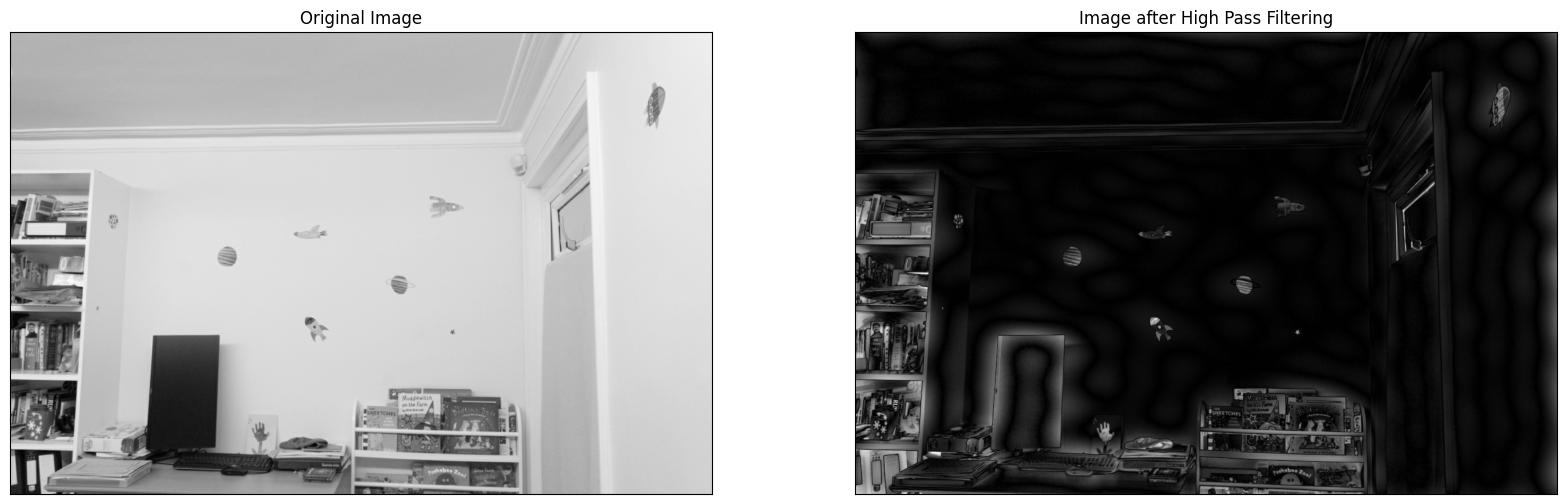

In [29]:

import numpy as np
import cv2
from matplotlib import pyplot as plt

# Load an image
image_path = 'dataset/db/playroom/images/DSC05572.jpg'  # Make sure to use the correct path to your image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load the image in grayscale

# Perform FFT to get the frequency domain representation
f = np.fft.fft2(image)
fshift = np.fft.fftshift(f)

# Get the dimensions of the image
rows, cols = image.shape
crow, ccol = rows // 2, cols // 2

# Define the radius for the high pass filter
radius = a  # This defines the cutoff frequency

# Create a high pass filter mask
mask = np.ones((rows, cols), np.uint8)
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= radius*radius
uuu = 
# print(mask_area)
mask[mask_area] = 0
# mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 ==0
# mask[mask_area] = 255

# Apply the mask to the shifted frequency domain representation
fshift = fshift * mask

# Perform the inverse FFT to get the image back
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

# Display the original and the high passed image
plt.figure(figsize=(20, 6))

plt.subplot(121), plt.imshow(image, cmap='gray'), plt.title('Original Image')
plt.xticks([]), plt.yticks([])

img_back_normalized = cv2.normalize(img_back, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

plt.subplot(122), plt.imshow(img_back_normalized, cmap='gray'), plt.title('Image after High Pass Filtering')
plt.xticks([]), plt.yticks([])

plt.show()

